# Buisness Problem


# Data Understanding

# Data Preperation

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt

import gzip
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from nltk.sentiment import SentimentIntensityAnalyzer

import re

import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [2]:
import seaborn as sns

In [3]:
import contractions

In [4]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [5]:
import pyLDAvis
import pyLDAvis.gensim_models

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Subsetting data

## Initial Pre-processing

# Data Exploration

## EDA

In [6]:
df = pd.read_csv('data/reviews_subset.csv')

In [ ]:
df.head()

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129550 entries, 0 to 129591
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     129550 non-null  float64
 1   reviewText  129550 non-null  object 
 2   verified    129550 non-null  bool   
 3   asin        129550 non-null  object 
 4   brand       129550 non-null  object 
 5   title       129550 non-null  object 
 6   sentiment   129550 non-null  int64  
 7   word_count  129550 non-null  int64  
 8   review_len  129550 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(4)
memory usage: 9.0+ MB


In [ ]:
df.isna().sum()

In [7]:
df.dropna(inplace = True)

In [ ]:
df.isna().sum()

In [8]:
df.overall.value_counts(normalize = True)

5.0    0.673987
4.0    0.171764
3.0    0.070853
1.0    0.047781
2.0    0.035616
Name: overall, dtype: float64

In [ ]:
ax = df.overall.value_counts().sort_index().plot(kind = 'bar',
                                            title = 'Count by Review Star',
                                            figsize = (10,5))
ax.set_xlabel('Review Stars');


In [ ]:
df.verified.value_counts()

In [ ]:
sns.barplot(data = df, x = 'verified', y = 'overall')

In [ ]:
df.brand.value_counts()

In [ ]:
dfg = df.groupby('brand')['overall'].mean().sort_values(ascending = False)

In [ ]:
fig, ax = plt.subplots(figsize = (10,30))
ax = sns.barplot(x = dfg.values, y = dfg.index, orient = 'h')

## Sentiment Validation of Star Ratings

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
df.reviewText[0]

In [ ]:
df.overall[0]

In [ ]:
sia.polarity_scores(df.reviewText[0])

In [ ]:
sent_val_df = df.copy()

In [ ]:
sent_val_df['compound'] = [sia.polarity_scores(str(x))['compound'] for x in df['reviewText']]
sent_val_df['neg'] = [sia.polarity_scores(str(x))['neg'] for x in df['reviewText']]
sent_val_df['neu'] = [sia.polarity_scores(str(x))['neu'] for x in df['reviewText']]
sent_val_df['pos'] = [sia.polarity_scores(str(x))['pos'] for x in df['reviewText']]

In [ ]:
sent_val_df.head()

In [ ]:
ax = sns.barplot(data = sent_val_df, x = 'overall', y = 'compound')

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data = sent_val_df, x = 'overall', y = 'pos', ax = axs[0])
sns.barplot(data = sent_val_df, x = 'overall', y = 'neu', ax = axs[1])
sns.barplot(data = sent_val_df, x = 'overall', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative');

In [9]:
def label_encode(x):
    if x <= 3:
        return 0
    if x > 3:
        return 1

In [10]:
df["sentiment"] = df["overall"].apply(lambda x: label_encode(x))

In [11]:
df['sentiment'].value_counts(normalize = True)

1    0.845751
0    0.154249
Name: sentiment, dtype: float64

## Text Exploration

In [12]:
def word_count(text):
    return len(word_tokenize(text))

def char_count(text):
    text_without_spaces = text.replace(" ", "")
    return len(text_without_spaces)

In [13]:
df['word_count'] = df.reviewText.apply(lambda x: word_count(x))
df['review_len'] = df.reviewText.apply(lambda x: char_count(x))

In [ ]:
df.head()

In [14]:
text_stats_df = df[['reviewText', 'sentiment', 'word_count', 'review_len']].copy()

In [15]:
text_stats_df.head()

,reviewText,sentiment,word_count,review_len
0,I bought this lens for my Rebel 2000 camera an...,1,54,207
1,Canon EF Lenses Have A Built In AF Motor..Comp...,1,211,952
2,I bought this lens about six months after repl...,1,191,727
3,Bought this as a replacement and it was worth ...,1,30,112
4,good,1,1,4


In [ ]:
text_stats_df.groupby('sentiment')['word_count'].mean().plot(kind = 'bar', figsize = (15,15));

In [ ]:
text_stats_df.groupby('sentiment')['review_len'].mean().plot(kind = 'bar', figsize = (15,15));

In [ ]:
correlation = text_stats_df[['sentiment', 'word_count', 'review_len']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(50,30))
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 40}, linewidths=10, vmin=-1.5, mask=mask);

In [16]:
text_stats_df.describe()

,sentiment,word_count,review_len
count,129550.000000,129550.000000,129550.000000
mean,0.845751,65.513192,252.553292
std,0.361189,112.072947,439.580095
min,0.000000,1.000000,1.000000
25%,1.000000,12.000000,47.000000
50%,1.000000,32.000000,122.000000
75%,1.000000,73.000000,280.000000
max,1.000000,4349.000000,18237.000000


In [ ]:
text_stats_df.word_count.hist();

In [ ]:
text_stats_df.review_len.hist();

In [ ]:
text_stats_df.sort_values(by = 'word_count', ascending = False).head(20)

In [ ]:
text_stats_df.sort_values(by = 'word_count', ascending = False).tail(20)

In [ ]:
text_stats_df.reviewText[44098]

In [20]:
def clean_text(text):
    
    text = text.lower()
    # Replace &nbsp; with regular space
    text = text.replace("&nbsp;", " ")
    # Remove HTML tags and attributes
    text = re.sub(r"<[^>]+>", "", text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove line breaks and extra whitespace
    text = re.sub(r"\s+", " ", text)
    # Remove numbers and special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenize with spaCy
    #doc = nlp(text)
    # Lemmatize and lowercase tokens
    #tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop and len(token) > 2]

    return text

In [ ]:
text_stats_df.reviewText[44098]

In [ ]:
clean_text(text_stats_df.reviewText[44098])

In [21]:
text_stats_df['cleaned_text'] = text_stats_df.reviewText.apply(lambda x: clean_text(x))

In [ ]:
text_stats_df.head()

In [ ]:
text_stats_df.cleaned_text[44098]

In [22]:
text_stats_df['cleaned_word_count'] = text_stats_df.cleaned_text.apply(lambda x: word_count(x))
text_stats_df['cleaned_review_len'] = text_stats_df.cleaned_text.apply(lambda x: char_count(x))

In [23]:
text_stats_df.describe()

,sentiment,word_count,review_len,cleaned_word_count,cleaned_review_len
count,129550.000000,129550.000000,129550.000000,129550.000000,129550.000000
mean,0.845751,65.513192,252.553292,56.496974,237.715029
std,0.361189,112.072947,439.580095,95.431282,405.602106
min,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,12.000000,47.000000,10.000000,44.000000
50%,1.000000,32.000000,122.000000,28.000000,117.000000
75%,1.000000,73.000000,280.000000,64.000000,266.000000
max,1.000000,4349.000000,18237.000000,3399.000000,15112.000000


In [83]:
text_stats_df[text_stats_df.cleaned_word_count == 0]

,reviewText,sentiment,word_count,review_len,cleaned_text,cleaned_word_count,cleaned_review_len
2861,http://www.amazon.com/gp/product/B00004ZCJL?re...,1,7,87,,0,0
3240,1,1,1,1,,0,0
3741,:),1,2,2,,0,0
6846,:-),1,3,3,,0,0
7307,"<div id=""video-block-R2PX631O5HPURN"" class=""a-...",1,57,345,,0,0
8645,:),1,2,2,,0,0
10734,5*,1,2,2,,0,0
10939,1,1,1,1,,0,0
21917,"<div id=""video-block-R3DCQ06IJNU0M2"" class=""a-...",0,57,345,,0,0
27020,:),1,2,2,,0,0


In [25]:
data_df = text_stats_df[text_stats_df.cleaned_word_count >0].copy()

In [ ]:
data_df = text_stats_df.copy()

In [26]:
data_df.describe()

,sentiment,word_count,review_len,cleaned_word_count,cleaned_review_len
count,129497.000000,129497.000000,129497.000000,129497.000000,129497.000000
mean,0.845703,65.537866,252.643969,56.520097,237.812320
std,0.361235,112.088937,439.644089,95.443963,405.656583
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,12.000000,47.000000,10.000000,44.000000
50%,1.000000,32.000000,123.000000,28.000000,117.000000
75%,1.000000,73.000000,280.000000,64.000000,266.000000
max,1.000000,4349.000000,18237.000000,3399.000000,15112.000000


In [27]:
stop_words = set(stopwords.words('english'))

In [ ]:
# edit stop words?
stop_words = set(nlp.Defaults.stop_words)

In [28]:
def count_stop_words(text):
    # Tokenize the text into words
    words = word_tokenize(text)

    # Convert the stop words set to lower case
    stop_words_lower = set([word.lower() for word in stop_words])

    # Count the number of stop words in the text using set intersection
    stop_word_count = len(set(words).intersection(stop_words_lower))

    return stop_word_count

In [29]:
data_df['cleaned_sw_count'] = data_df.cleaned_text.apply(lambda x: count_stop_words(x))

In [30]:
data_df.describe()

,sentiment,word_count,review_len,cleaned_word_count,cleaned_review_len,cleaned_sw_count
count,129497.000000,129497.000000,129497.000000,129497.000000,129497.000000,129497.000000
mean,0.845703,65.537866,252.643969,56.520097,237.812320,13.985081
std,0.361235,112.088937,439.644089,95.443963,405.656583,13.018421
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,47.000000,10.000000,44.000000,4.000000
50%,1.000000,32.000000,123.000000,28.000000,117.000000,11.000000
75%,1.000000,73.000000,280.000000,64.000000,266.000000,20.000000
max,1.000000,4349.000000,18237.000000,3399.000000,15112.000000,103.000000


In [ ]:
cv = CountVectorizer(min_df = 10, ngram_range = (3,3), stop_words = stop_words)
cv.fit_transform(data_df.cleaned_text)


In [67]:
print(nlp.Defaults.stop_words)

{'its', 'over', 'say', 'behind', 'though', 'twenty', 'off', 'your', 'whole', 'only', 'among', 'already', 'hers', 'next', 'together', 'more', 'is', 'used', 'whereupon', 'below', 'down', 'yourself', 'nor', 'also', 'elsewhere', 'once', 'if', '‘d', 'around', 'would', 'because', 'along', 'myself', 'this', 'take', 'five', 'twelve', 'forty', 'during', 'whatever', 'yourselves', 'whence', 'several', 'through', 'as', 'above', 'under', 'do', 'less', 'ourselves', 'make', 'other', 'into', 'their', 'thereafter', 'someone', 'moreover', 'to', 'please', 'there', 'eight', 'become', 'must', 'us', 'nobody', 'not', 'various', 'anywhere', 'here', 'about', 'four', 'who', 'for', 'everything', 'neither', 'none', 'ten', 'whereas', 'will', 'nevertheless', 'throughout', 'besides', 'just', 'fifteen', 'being', 'part', 'had', 'seems', "'m", 'call', 'former', 'put', '‘ve', 'anyway', 'now', 'she', 'name', 'per', 'out', 'against', 'mine', 'seeming', 'made', 'ever', 'any', 'another', '‘ll', 'others', 'been', 'six', 'thi

In [31]:
def top_words(text, n = None, ngram = (1,1), stop_words = None):
    cv = CountVectorizer(ngram_range = ngram, stop_words = stop_words)
    words = cv.fit_transform(text)
    sum_words = words.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    word_df = pd.DataFrame(word_freq, columns=['word', 'count'])
    return word_df[:n]

In [32]:
top30 = top_words(text = data_df.cleaned_text, n = 30)
top30_sw = top_words(text = data_df.cleaned_text, n = 30, stop_words = stop_words)

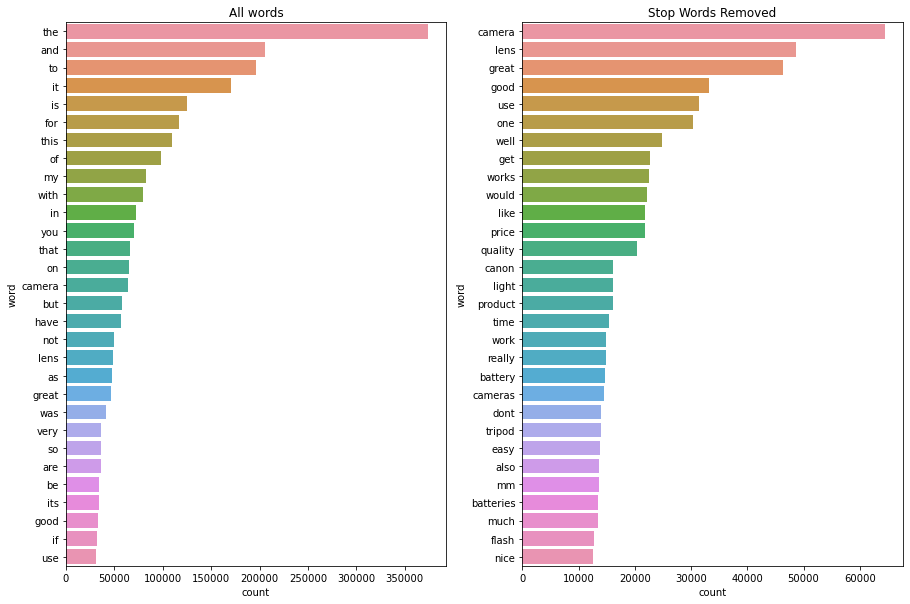

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
sns.barplot(data = top30, x = 'count', y = 'word', orient = 'h', ax = axs[0])
sns.barplot(data = top30_sw, x = 'count', y = 'word', orient = 'h', ax = axs[1])
axs[0].set_title('All words')
axs[1].set_title('Stop Words Removed');

In [34]:
top30_bigrams = top_words(text = data_df.cleaned_text, n = 30, ngram = (2,2))
top30_bigrams_sw = top_words(text = data_df.cleaned_text, n = 30, ngram = (2,2), stop_words = stop_words)

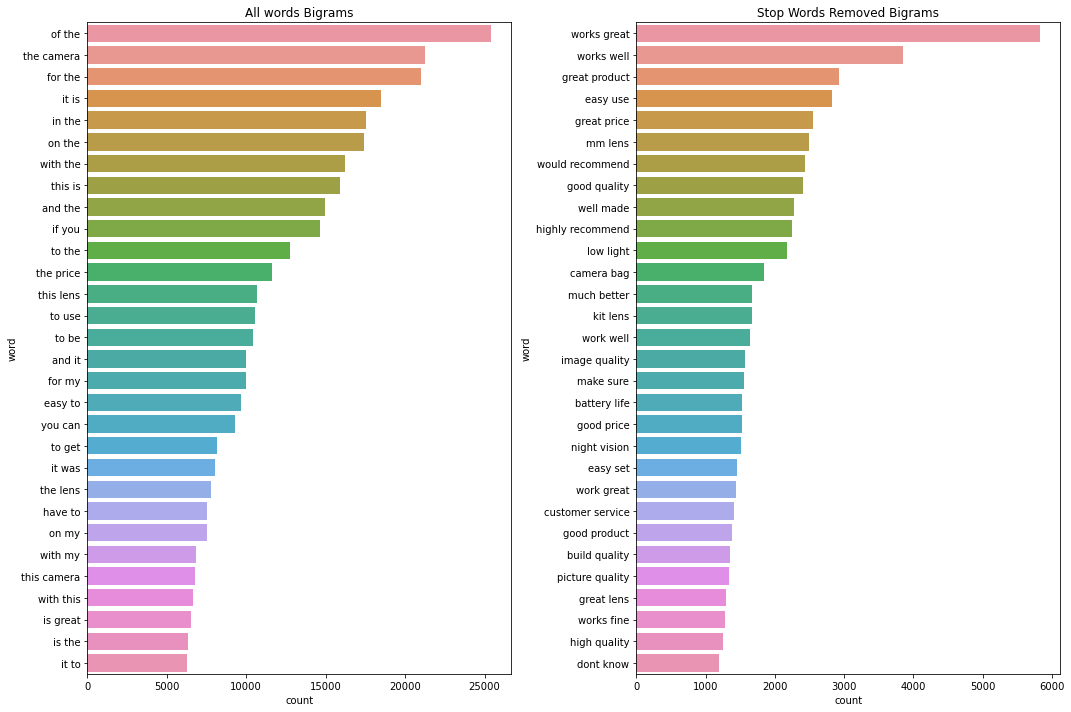

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
sns.barplot(data = top30_bigrams, x = 'count', y = 'word', orient = 'h', ax = axs[0])
sns.barplot(data = top30_bigrams_sw, x = 'count', y = 'word', orient = 'h', ax = axs[1])
axs[0].set_title('All words Bigrams')
axs[1].set_title('Stop Words Removed Bigrams')
fig.tight_layout();

In [36]:
top30_trigrams = top_words(text = data_df.cleaned_text, n = 30, ngram = (3,3))
top30_trigrams_sw = top_words(text = data_df.cleaned_text, n = 30, ngram = (3,3), stop_words = stop_words)

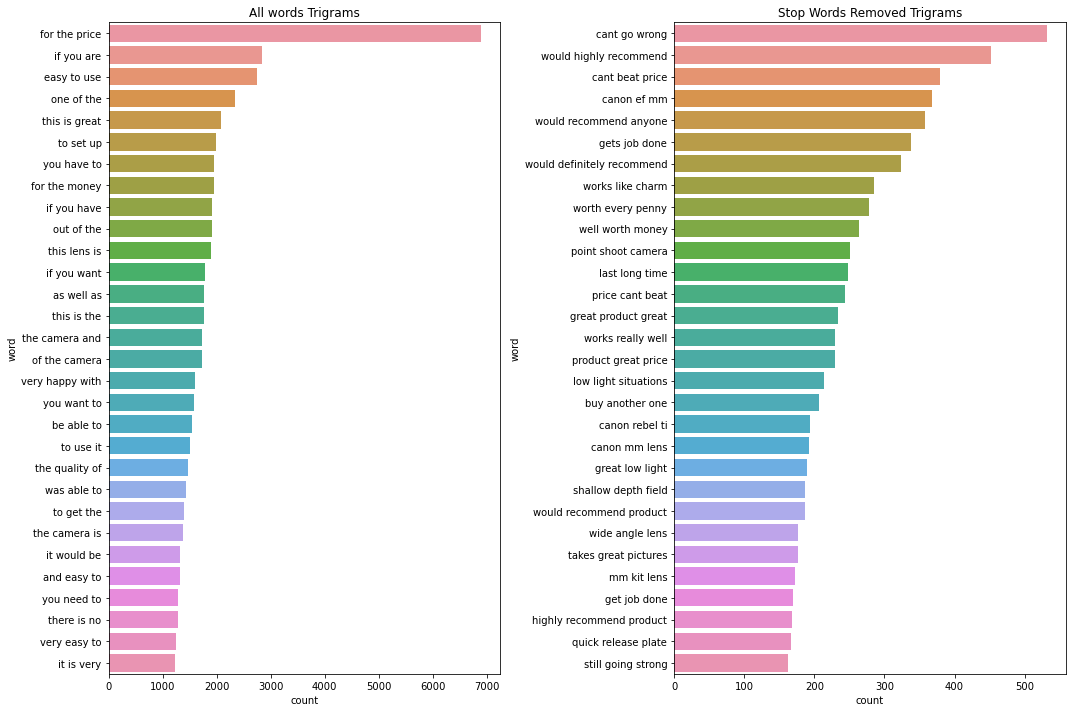

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(15,10))
sns.barplot(data = top30_trigrams, x = 'count', y = 'word', orient = 'h', ax = axs[0])
sns.barplot(data = top30_trigrams_sw, x = 'count', y = 'word', orient = 'h', ax = axs[1])
axs[0].set_title('All words Trigrams')
axs[1].set_title('Stop Words Removed Trigrams')
fig.tight_layout();

In [38]:
data_df.describe()

,sentiment,word_count,review_len,cleaned_word_count,cleaned_review_len,cleaned_sw_count
count,129497.000000,129497.000000,129497.000000,129497.000000,129497.000000,129497.000000
mean,0.845703,65.537866,252.643969,56.520097,237.812320,13.985081
std,0.361235,112.088937,439.644089,95.443963,405.656583,13.018421
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,47.000000,10.000000,44.000000,4.000000
50%,1.000000,32.000000,123.000000,28.000000,117.000000,11.000000
75%,1.000000,73.000000,280.000000,64.000000,266.000000,20.000000
max,1.000000,4349.000000,18237.000000,3399.000000,15112.000000,103.000000


<AxesSubplot:>

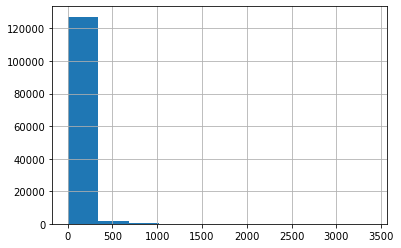

In [40]:
data_df.cleaned_word_count.hist()

In [39]:
data_df[data_df.cleaned_word_count <= 1000]

,reviewText,sentiment,word_count,review_len,cleaned_text,cleaned_word_count,cleaned_review_len,cleaned_sw_count
0,I bought this lens for my Rebel 2000 camera an...,1,54,207,i bought this lens for my rebel camera and ha...,48,195,16
1,Canon EF Lenses Have A Built In AF Motor..Comp...,1,211,952,canon ef lenses have a built in af motorcompar...,169,872,23
2,I bought this lens about six months after repl...,1,191,727,i bought this lens about six months after repl...,169,698,40
3,Bought this as a replacement and it was worth ...,1,30,112,bought this as a replacement and it was worth ...,26,106,9
4,good,1,1,4,good,1,4,0
...,...,...,...,...,...,...,...,...
129587,I have two original 720 Yi Home Camera that be...,0,26,115,i have two original yi home camera that been ...,21,104,6
129588,Thanks!,1,2,7,thanks,1,6,0
129589,"First of all, this is similar to, but not a re...",1,256,852,first of all this is similar to but not a rebr...,219,801,41
129590,"After some recent thefts in the neighborhood, ...",1,133,544,after some recent thefts in the neighborhood i...,116,524,35


In [41]:
def preprocess(text):
    doc = nlp(text)
    # Lemmatize and lowercase tokens
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop and len(token) > 2]
    return tokens

In [42]:
data_df['processed_text'] = data_df['cleaned_text'].apply(lambda x: preprocess(x))

In [43]:
data_words = data_df.processed_text

In [44]:
data_words

0         [buy, lens, rebel, camera, pleased, result, us...
1         [canon, lense, build, motorcompare, camera, bo...
2         [buy, lens, month, replace, year, old, slr, ca...
3         [buy, replacement, worth, money, spend, new, p...
4                                                    [good]
                                ...                        
129587    [original, home, camera, work, incredibly, mon...
129588                                              [thank]
129589    [similar, rebranded, nest, cam, nest, wide, an...
129590    [recent, theft, neighborhood, buy, couple, cam...
129591    [entire, setup, little, quirky, buy, cam, car,...
Name: processed_text, Length: 129497, dtype: object

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [49]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

In [45]:
from gensim.models.phrases import Phrases, Phraser

# Create bigrams
bigram = Phrases(data_words, min_count=5, threshold=50)
bigram_phraser = Phraser(bigram)
bigram_docs = [bigram_phraser[doc] for doc in data_words]

# Create trigrams
trigram = Phrases(bigram_docs, min_count=5, threshold=50)
trigram_phraser = Phraser(trigram)
trigram_docs = [trigram_phraser[doc] for doc in bigram_docs]


In [46]:
id2word = corpora.Dictionary(trigram_docs)

# Create Corpus
texts = trigram_docs

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]]


In [47]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='symmetric',
                                           per_word_topics=True)

In [ ]:
cv = CountVectorizer(min_df = 10, ngram_range = (1,3), stop_words = stop_words)
X = cv.fit_transform(data_df.cleaned_text)

In [ ]:
cv.get_feature_names()

In [ ]:
id2word = corpora.Dictionary([cv.get_feature_names()])

# Convert the count matrix to gensim corpus
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

# Define your LDA model
num_topics = 10
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=5)

In [ ]:
id2word = corpora.Dictionary(trigram_docs)

# Create Corpus
texts = trigram_docs

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                num_topics=num_topics, 
                                                id2word=id2word, 
                                                passes = 5,
                                                update_every = 1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [54]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus, 
                                                        texts=trigram_docs, 
                                                        start=2, limit=26, step=3)

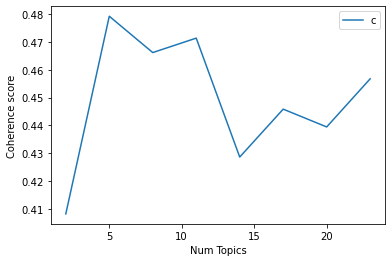

In [55]:
# Show graph
limit=26; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [56]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4082
Num Topics = 5  has Coherence Value of 0.4793
Num Topics = 8  has Coherence Value of 0.4662
Num Topics = 11  has Coherence Value of 0.4714
Num Topics = 14  has Coherence Value of 0.4286
Num Topics = 17  has Coherence Value of 0.4459
Num Topics = 20  has Coherence Value of 0.4395
Num Topics = 23  has Coherence Value of 0.4568


In [64]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.026*"picture" + 0.024*"camera" + 0.015*"lens" + 0.014*"use" + 0.013*"love" + 0.012*"great" + 0.012*"image" + 0.012*"light" + 0.011*"photo" + 0.011*"quality"'), (1, '0.023*"work" + 0.021*"buy" + 0.014*"get" + 0.013*"time" + 0.012*"try" + 0.012*"review" + 0.012*"product" + 0.011*"go" + 0.011*"day" + 0.011*"send"'), (2, '0.058*"camera" + 0.016*"work" + 0.014*"app" + 0.014*"system" + 0.014*"set" + 0.012*"easy" + 0.012*"video" + 0.011*"use" + 0.010*"setup" + 0.010*"phone"'), (3, '0.143*"great" + 0.094*"work" + 0.086*"good" + 0.063*"price" + 0.054*"product" + 0.048*"quality" + 0.022*"excellent" + 0.017*"buy" + 0.016*"easy" + 0.014*"nice"'), (4, '0.039*"camera" + 0.031*"fit" + 0.027*"case" + 0.020*"bag" + 0.019*"lens" + 0.017*"small" + 0.017*"love" + 0.017*"hold" + 0.016*"battery" + 0.014*"canon"')]


In [65]:
lda_model = model_list[1]

In [66]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.058050 -0.028626       1        1  32.439518
2      0.183869  0.039704       2        1  25.851976
4      0.070239 -0.250234       3        1  18.372414
1      0.025721  0.255070       4        1  14.715873
3     -0.337880 -0.015914       5        1   8.620220, topic_info=        Term          Freq         Total Category  logprob  loglift
46     great  53082.000000  53082.000000  Default  30.0000  30.0000
151     work  49543.000000  49543.000000  Default  29.0000  29.0000
9       good  38190.000000  38190.000000  Default  28.0000  28.0000
148    price  21433.000000  21433.000000  Default  27.0000  27.0000
156  quality  24813.000000  24813.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
445     fine   1349.787399   5233.262890   Topic5  -5.2509   1.0960
381     need   2186.138652  19768.242063   Topic5  -4.7687   0.2491
18       use   2170.162521  30869.626648   Topic5  -4.7761  -0.2039
325  perfect   1493.290838   9806.535336   Topic5  -5.1499   0.5690
284     time   1558.899699  18844.606316   Topic5  -5.1069  -0.0412

[358 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
179       1  0.309056       able
179       2  0.561833       able
179       3  0.122096       able
179       4  0.006995       able
848       3  0.999943  accessory
...     ...       ...        ...
143       4  0.714056       year
1890      3  0.998093        zip
1891      3  0.999711     zipper
93        1  0.930217       zoom
93        3  0.069593       zoom

[609 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

In [90]:
data = data_df.reviewText

,overall,reviewText,verified,asin,brand,title,sentiment,word_count,review_len
0,4.0,I bought this lens for my Rebel 2000 camera an...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,1,54,207
1,4.0,Canon EF Lenses Have A Built In AF Motor..Comp...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,1,211,952
2,5.0,I bought this lens about six months after repl...,False,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,1,191,727
3,5.0,Bought this as a replacement and it was worth ...,True,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,1,30,112
4,5.0,good,True,B00004THD0,Canon,Canon EF 75-300mm f/4-5.6 III Telephoto Zoom L...,1,1,4


In [70]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [71]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

In [72]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [73]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9593,"picture, camera, lens, use, love, great, image...",I bought this lens for my Rebel 2000 camera an...
1,1,0.0,0.8632,"picture, camera, lens, use, love, great, image...",Canon EF Lenses Have A Built In AF Motor..Comp...
2,2,0.0,0.6468,"picture, camera, lens, use, love, great, image...",I bought this lens about six months after repl...
3,3,1.0,0.5476,"work, buy, get, time, try, review, product, go...",Bought this as a replacement and it was worth ...
4,4,3.0,0.5993,"great, work, good, price, product, quality, ex...",good
5,5,3.0,0.7328,"great, work, good, price, product, quality, ex...",good for starters.
6,6,1.0,0.7294,"work, buy, get, time, try, review, product, go...",Just like new...
7,7,3.0,0.6165,"great, work, good, price, product, quality, ex...",It fit my canon camera and works greats. The p...
8,8,3.0,0.3924,"great, work, good, price, product, quality, ex...","Good for the price. The image quality is good,..."
9,9,3.0,0.7989,"great, work, good, price, product, quality, ex...",Great Product would purchase again.


In [88]:
df_dominant_topic.isna().sum()

Document_No            0
Dominant_Topic        95
Topic_Perc_Contrib    95
Keywords              95
Text                  95
dtype: int64

In [74]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"picture, camera, lens, use, love, great, image...",34244.0,0.2644
1.0,0.0,"picture, camera, lens, use, love, great, image...",13073.0,0.1010
2.0,0.0,"picture, camera, lens, use, love, great, image...",23867.0,0.1843
3.0,1.0,"work, buy, get, time, try, review, product, go...",27702.0,0.2139
4.0,3.0,"great, work, good, price, product, quality, ex...",30611.0,0.2364
...,...,...,...,...
129587.0,NaN,NaN,NaN,NaN
129588.0,NaN,NaN,NaN,NaN
129589.0,NaN,NaN,NaN,NaN
129590.0,NaN,NaN,NaN,NaN


In [76]:
df_dominant_topics.isna().sum()

Dominant_Topic        95
Topic_Keywords        95
Num_Documents     129587
Perc_Documents    129587
dtype: int64

In [77]:
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"picture, camera, lens, use, love, great, image...",34244.0,0.2644
1.0,0.0,"picture, camera, lens, use, love, great, image...",13073.0,0.1010
2.0,0.0,"picture, camera, lens, use, love, great, image...",23867.0,0.1843
3.0,1.0,"work, buy, get, time, try, review, product, go...",27702.0,0.2139
4.0,3.0,"great, work, good, price, product, quality, ex...",30611.0,0.2364
5.0,3.0,"great, work, good, price, product, quality, ex...",NaN,NaN
6.0,1.0,"work, buy, get, time, try, review, product, go...",NaN,NaN
7.0,3.0,"great, work, good, price, product, quality, ex...",NaN,NaN
8.0,3.0,"great, work, good, price, product, quality, ex...",NaN,NaN
9.0,3.0,"great, work, good, price, product, quality, ex...",NaN,NaN
